In [2]:
import time
import warnings
import operator
import statistics
import seaborn as sns
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import pandas_profiling
import numpy as np
import warnings
import sklearn


from dateutil.parser import parse
from datetime import datetime
from scipy import stats
from IPython.display import display_html
from multiprocessing import Pool
from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from pprint import pprint

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

#### **User Defined Functions**

In [3]:
# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# get names of all categorical data present in data
def get_index_of_categorical_columns(df):
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))


def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

#### **Store feature names in dataframe**

In [4]:
features_list = ['windDir100mAvg', 'POWER_OUT_CLUE_FLG_True', 'Hour_Cos', 'FUSE_OCCURN_FLG_False', 'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'Outages_in_last_1hr',
                 'Priority_Customer_Qty', 'ANIMAL_CAUSE_FLG_False', 'UG_CAUSE_FLG_False', 'tempRange', 'NO_OF_WIRE_OCCURN_PER_DAY', 'radSolarTot', 'PUBLIC_SAFETY_OCCURN_FLG_True',
                 'Outages_in_last_10hr', 'NO_CAUSE_FLG_False', 'cldCvrRange', 'windSpd80mMax', 'Hour_Sin', 'CALL_QTY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'TREE_CAUSE_FLG_True',
                 'Outages_in_last_2hr', 'TREE_CAUSE_FLG_False', 'Priority_Dist_Customer_Qty', 'relHumAvg', 'POLE_CLUE_FLG_False', 'DOWNSTREAM_CUST_QTY', 'Outages_in_last_9hr',
                 'heatIndexMax', 'DAY_FLAG_True', 'WIRE_OCCURN_FLG_False', 'ANIMAL_CAUSE_FLG_True', 'ST_OCCURN_FLG_False', 'CITY_NAM_NO_CITY', 'PUBLIC_SAFETY_OCCURN_FLG_False',
                 'ST_OCCURN_FLG_True', 'POWER_OUT_CLUE_FLG_False']

In [5]:
features_df = pd.DataFrame({'ModelObject':'Random_Forest_GridSearch_09172020', 'Features_List': features_list})
features_df.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/Random_Forest_GridSearch_09172020.csv')

#### **Load 2020 Storms Validation Dataset**

In [6]:
df_ads = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_V10.4.2020_09222020.csv')
df_ads.head()

,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Marker_Location,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,LIVE_OUTAGE,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Live_outage_group,Priority_Customer_Qty,Dis_From_Live_Centriod_div_Cust_qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrMin,cldCvrAvg,cldCvrMax,dewPtMin,dewPtAvg,dewPtMax,feelsLikeMin,feelsLikeAvg,feelsLikeMax,heatIndexMin,heatIndexAvg,heatIndexMax,mslPresMin,mslPresAvg,mslPresMax,precip,radSolarAvg,radSolarMax,radSolarTot,relHumMin,relHumAvg,relHumMax,sfcPresMin,sfcPresAvg,sfcPresMax,snowfall,spcHumMin,spcHumAvg,spcHumMax,tempMin,tempAvg,tempMax,windChillMin,windChillAvg,windChillMax,windDirAvg,windDir80mAvg,windDir100mAvg,windSpdMin,windSpdAvg,windSpdMax,windSpd80mMin,windSpd80mAvg,windSpd80mMax,windSpd100mMin,windSpd100mAvg,windSpd100mMax,wetBulbMin,wetBulbAvg,wetBulbMax,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,Active_no_of_trucks_per_day
0,2002645939,2001465208.00,462-B/97,BLUE SKY,2020-01-01 00:03:00,2020-01-01 02:30:00,3209.00,FUSE,320.00,26,30.00,1.00,2020-01-01 03:45:00,30.00,False,147.00,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,INDIANAPOLIS,39.79,-86.19,ZONE4,37,2,17,8,5,Marker11,0.00,1.00,1.00,0,0,0,0,0,0,0,0,0,0,0,Wednesday,False,1,1.00,0.18,1.00,MILL,0.00,27.00,100.00,25.50,27.90,29.80,26.20,33.40,42.80,31.80,38.60,46.70,1007.00,1010.70,1013.50,0.00,118.60,499.20,2846.90,43.20,67.00,89.00,981.60,984.80,987.40,0.00,3.00,3.30,3.50,31.80,38.60,46.70,26.20,33.40,42.80,220.00,216.00,218.00,5.00,7.20,10.40,12.50,18.00,28.60,13.00,17.90,27.70,30.50,34.70,39.30,14.90,5.40,5.80,100.00,45.80,2.06,1.01,nan
1,2002646057,2001465296.00,281-B/193,BLUE SKY,2020-01-01 03:10:16,2020-01-01 11:46:19,3607.00,FUSE,360.00,3,2.00,0.00,2020-01-01 07:45:00,2.00,False,516.05,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,INDIANAPOLIS,39.88,-86.02,ZONE3,37,2,17,8,5,Marker5,0.71,0.71,3.00,0,0,0,1,2,2,2,2,2,2,2,Wednesday,False,2,1.00,0.00,1.00,ARL.,0.00,28.00,100.00,26.40,28.20,30.60,25.50,32.00,41.70,31.90,37.70,45.80,1007.

In [7]:
df_ads = pd.get_dummies(df_ads, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

#### **Subset Analytical Dataset using features list**

In [8]:
df_ads_v1 = df_ads[features_list]

In [9]:
df_ads_v1.head()

,windDir100mAvg,POWER_OUT_CLUE_FLG_True,Hour_Cos,FUSE_OCCURN_FLG_False,NO_OF_IVR_CLUE_PER_DAY,NO_OF_POWER_OUT_CLUE_PER_DAY,Outages_in_last_1hr,Priority_Customer_Qty,ANIMAL_CAUSE_FLG_False,UG_CAUSE_FLG_False,tempRange,NO_OF_WIRE_OCCURN_PER_DAY,radSolarTot,PUBLIC_SAFETY_OCCURN_FLG_True,Outages_in_last_10hr,NO_CAUSE_FLG_False,cldCvrRange,windSpd80mMax,Hour_Sin,CALL_QTY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,TREE_CAUSE_FLG_True,Outages_in_last_2hr,TREE_CAUSE_FLG_False,Priority_Dist_Customer_Qty,relHumAvg,POLE_CLUE_FLG_False,DOWNSTREAM_CUST_QTY,Outages_in_last_9hr,heatIndexMax,DAY_FLAG_True,WIRE_OCCURN_FLG_False,ANIMAL_CAUSE_FLG_True,ST_OCCURN_FLG_False,CITY_NAM_NO_CITY,PUBLIC_SAFETY_OCCURN_FLG_False,ST_OCCURN_FLG_True,POWER_OUT_CLUE_FLG_False
0,218.00,1,1.00,0,17,37,0,1.00,1,1,14.90,5,2846.90,0,0,1,100.00,28.60,0.00,26,2,0,0,1,1.00,67.00,1,30.00,0,46.70,0,1,0,1,0,1,0,0
1,220.00,0,0.71,0,17,37,0,1.00,1,1,13.90,5,2829.40,0,2,1,100.00,28.40,0.71,3,2,0,0,1,1.00,69.90,1,2.00,2,45.80,0,1,0,1,0,1,0,1
2,220.00,1,0.71,1,17,37,0,1.00,1,1,13.90,5,2829.40,0,2,1,100.00,28.40,0.71,3,2,0,0,1,1.00,69.90,1,10.00,2,45.80,0,0,0,1,0,1,0,0
3,220.00,1,0.71,1,17,37,0,2.00,1,1,13.90,5,2829.40,0,2,1,100.00,28.40,0.71,70,2,0,0,1,1.00,69.90,1,205.00,2,45.80,0,0,0,1,0,1,0,0
4,220.00,1,0.71,1,17,37,3,18.00,1,1,14.10,5,2817.30,0,5,1,100.00,28.00,0.71,1,2,0,3,1,23.00,69.00,1,2.00,5,46.00,0,1,0,1,0,1,0,0


#### **Load IPL Analytical Dataset v10.4.0**

In [9]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')
fs.ls('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles')
with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/Random_Forest_GridSearch_09172020.pkl', 'rb') as f:
    rf_model = pickle.load(f)

In [13]:
storm_col_2020 = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
storm_result_df_2020 = pd.DataFrame(columns=storm_col_2020)
storm_test_list_2020 = pd.DataFrame() 
i=0

In [14]:
X = df_ads_v1[features_list]
y = df_ads.TTR

y_test_pred = rf_model.predict(X)
y_test_pred = np.exp(y_test_pred)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'Random_Forest_Hyper_Parameter_Tuned', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
storm_test_list_2020 = storm_test_list_2020.append(data_test)
storm_test_list_2020.reset_index(drop=True, inplace=True)

storm_result_df_2020.loc[i] = ['Random_Forest_Hyper_Parameter_Tuned', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [15]:
storm_result_df_2020.head()

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random_Forest_Hyper_Parameter_Tuned,827300.29,909.56,183.16,134.59,0.06


Text(0.5, 1.0, 'Actual vs Fitted : Random Forest Random Search')

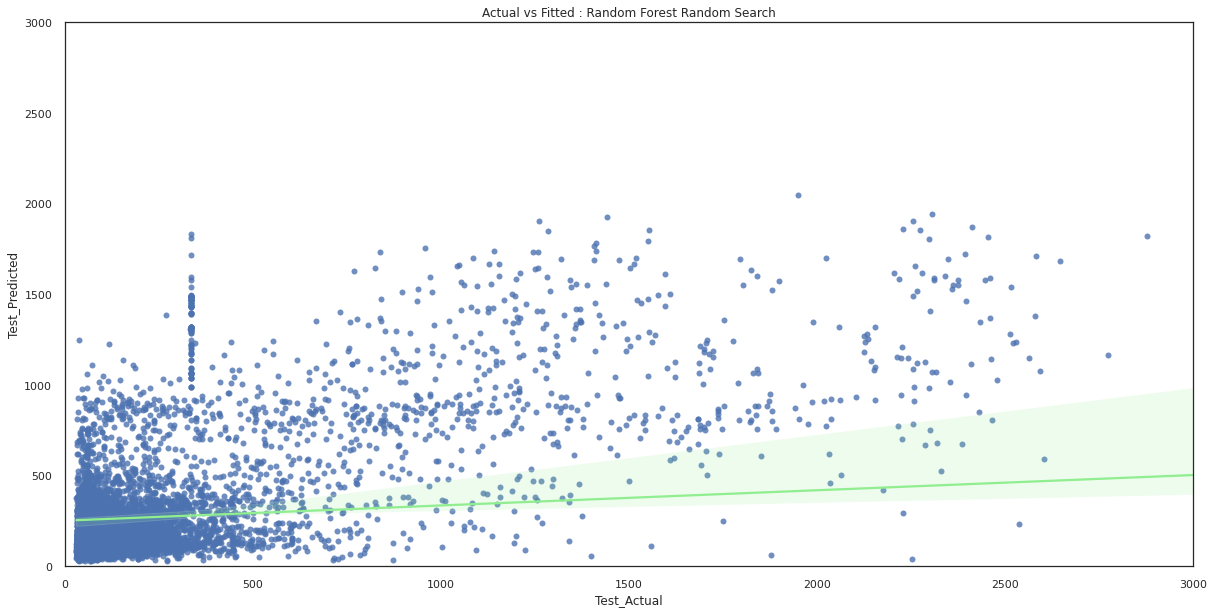

In [17]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=storm_test_list_2020[storm_test_list_2020.Model=='Random_Forest_Hyper_Parameter_Tuned'], line_kws={"color": "lightgreen"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Random Search')

In [19]:
storm_test_list_2020.head()

,Model,Test_Predicted,Test_Actual
0,Random_Forest_Hyper_Parameter_Tuned,91.83,147.00
1,Random_Forest_Hyper_Parameter_Tuned,48.16,516.05
2,Random_Forest_Hyper_Parameter_Tuned,97.99,133.42
3,Random_Forest_Hyper_Parameter_Tuned,99.88,68.20
4,Random_Forest_Hyper_Parameter_Tuned,143.06,81.25


In [20]:
storm_test_list_2020.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/2020_validation_HPTRF.csv')

#### **Load and subset feature names**

#### **Load Model Object**